In [24]:
import sys
import platform

print("Python version:", sys.version)
print("Platform:", platform.platform())


Python version: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26200-SP0


torch → xây & train YOLO

torchvision → xử lý ảnh, transform

torchaudio → xử lý âm thanh hay cài kèm chung bộ torch cho đủ comb

opencv-python → đọc ảnh, vẽ bbox, webcam real-time

matplotlib → vẽ biểu đồ, hiển thị ảnh kết quả

numpy → tính toán nền (ma trận, bbox, v.v.)

tqdm → progress bar đẹp khi train & preprocess

In [25]:
!pip install torch 


In [26]:
!pip install torchvision 

In [27]:
!pip install opencv-python 

In [28]:
!pip install matplotlib 

In [29]:
!pip install numpy 

In [30]:
!pip install tqdm

In [31]:
import sys
print("Python:", sys.version)
print("Executable:", sys.executable)

import torch, torchvision, cv2, numpy as np, matplotlib
print("torch      :", torch.__version__)
print("torchvision:", torchvision.__version__)
print("opencv     :", cv2.__version__)
print("numpy      :", np.__version__)
print("matplotlib :", matplotlib.__version__)
print("CUDA avail :", torch.cuda.is_available())


Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
Executable: c:\Users\kimli\anaconda3\envs\facemask_env\python.exe
torch      : 2.9.1+cpu
torchvision: 0.24.1+cpu
opencv     : 4.12.0
numpy      : 2.1.2
matplotlib : 3.10.7
CUDA avail : False


In [32]:
import torch

print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Current device:", torch.cuda.current_device())
else:
    print("Không có GPU CUDA, sẽ train bằng CPU (sẽ chậm hơn).")


CUDA available: False
Không có GPU CUDA, sẽ train bằng CPU (sẽ chậm hơn).


In [33]:
# Khai báo đường dẫn PROJECT & DATASET
import os

PROJECT_ROOT = r"D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo"

DATASET_ROOT = os.path.join(PROJECT_ROOT, "1.Dataset")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATASET_ROOT:", DATASET_ROOT)

SRC_DIR = os.path.join(PROJECT_ROOT, "3. src") 
print("SRC_DIR:", SRC_DIR)


PROJECT_ROOT: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo
DATASET_ROOT: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset
SRC_DIR: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\3. src


In [34]:
import sys

if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

print("sys.path has SRC_DIR:", SRC_DIR in sys.path)



sys.path has SRC_DIR: True


In [35]:
train_dir = os.path.join(DATASET_ROOT, "Train")
val_dir  = os.path.join(DATASET_ROOT, "Val")

print("Train dir exists:", os.path.isdir(train_dir))
print("Val dir exists :", os.path.isdir(val_dir))

train_img_dir = os.path.join(train_dir, "pictures")
train_ann_dir = os.path.join(train_dir, "annotations")

val_img_dir = os.path.join(val_dir, "pictures")
val_ann_dir = os.path.join(val_dir, "annotations")

print("Train pictures dir:", train_img_dir, "->", os.path.isdir(train_img_dir))
print("Train ann dir   :", train_ann_dir, "->", os.path.isdir(train_ann_dir))
print("Val pictures dir :", val_img_dir, "->", os.path.isdir(val_img_dir))
print("Val ann dir    :", val_ann_dir, "->", os.path.isdir(val_ann_dir))


Train dir exists: True
Val dir exists : True
Train pictures dir: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\Train\pictures -> True
Train ann dir   : D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\Train\annotations -> True
Val pictures dir : D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\Val\pictures -> True
Val ann dir    : D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\Val\annotations -> True


## Test đọc 1 ảnh + 1 file XML


Số ảnh train: 7385
Sample image: 000526.jpg
XML path: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\Train\annotations\000526.xml -> True
Image shape (h, w): 458 305


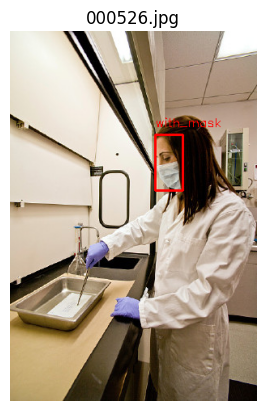

In [36]:
import random
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import cv2

# Lấy ngẫu nhiên 1 file ảnh trong Train
sample_images = [f for f in os.listdir(train_img_dir)
                 if f.lower().endswith((".jpg", ".jpeg", ".png"))]

print("Số ảnh train:", len(sample_images))

sample_img_name = random.choice(sample_images)
print("Sample image:", sample_img_name)

img_path = os.path.join(train_img_dir, sample_img_name)
xml_path = os.path.join(train_ann_dir,
                        os.path.splitext(sample_img_name)[0] + ".xml")

print("XML path:", xml_path, "->", os.path.exists(xml_path))

# Đọc ảnh
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Đọc XML & vẽ bbox thử
tree = ET.parse(xml_path)
root = tree.getroot()

h, w, _ = img.shape
print("Image shape (h, w):", h, w)

for obj in root.findall("object"):
    name = obj.find("name").text
    bbox = obj.find("bndbox")
    xmin = int(float(bbox.find("xmin").text))
    ymin = int(float(bbox.find("ymin").text))
    xmax = int(float(bbox.find("xmax").text))
    ymax = int(float(bbox.find("ymax").text))

    cv2.rectangle(img_rgb, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    cv2.putText(img_rgb, name, (xmin, ymin-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

plt.imshow(img_rgb)
plt.axis("off")
plt.title(sample_img_name)
plt.show()


In [37]:
print("Môi trường đã sẵn sàng!")
print("- Project root:", PROJECT_ROOT)
print("- Dataset root:", DATASET_ROOT)
print("- Train images:", train_img_dir)
print("- val images :", val_img_dir)
print("- CUDA:", torch.cuda.is_available())


Môi trường đã sẵn sàng!
- Project root: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo
- Dataset root: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset
- Train images: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\Train\pictures
- val images : D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\Val\pictures
- CUDA: False


In [38]:
import os

# Thư mục mới để lưu dataset dạng YOLO
out_root = os.path.join(DATASET_ROOT, "PWMFD_YOLO")

out_train_img   = os.path.join(out_root, "train", "images")
out_train_label = os.path.join(out_root, "train", "labels")
out_val_img     = os.path.join(out_root, "val", "images")
out_val_label   = os.path.join(out_root, "val", "labels")

for d in [out_train_img, out_train_label, out_val_img, out_val_label]:
    os.makedirs(d, exist_ok=True)

print("Output root:", out_root)
print("Train images out:", out_train_img)
print("Train labels out:", out_train_label)
print("Val images out:", out_val_img)
print("Val labels out:", out_val_label)


Output root: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO
Train images out: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\train\images
Train labels out: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\train\labels
Val images out: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\val\images
Val labels out: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\val\labels


In [ ]:
# Map tên class trong XML sang ID class cho YOLO
class_map = {
    "with_mask": 0,
    "incorrect_mask": 1,
    "without_mask": 2
}

class_map


{'with_mask': 0, 'incorrect_mask': 1, 'without_mask': 2}

In [ ]:
import xml.etree.ElementTree as ET

def convert_xml_to_yolo(xml_file, label_out_path):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find("size")
    img_w = int(size.find("width").text)
    img_h = int(size.find("height").text)

    lines = []

    for obj in root.findall("object"):
        name = obj.find("name").text.strip()

        if name not in class_map:
            print(f" Unknown class '{name}' in {xml_file}, bỏ qua.")
            continue

        cls_id = class_map[name]

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)

        # Convert sang YOLO format (chuẩn hóa về [0,1])
        x_center = (xmin + xmax) / 2.0 / img_w
        y_center = (ymin + ymax) / 2.0 / img_h
        w = (xmax - xmin) / img_w
        h = (ymax - ymin) / img_h

        lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

    # Ghi ra file .txt
    with open(label_out_path, "w") as f:
        f.writelines(lines)


In [39]:
import os, shutil

train_images = [f for f in os.listdir(train_img_dir)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))]

print("Số ảnh Train:", len(train_images))

for img_name in train_images:
    src_img = os.path.join(train_img_dir, img_name)
    dst_img = os.path.join(out_train_img, img_name)
    shutil.copy(src_img, dst_img)

    xml_name = os.path.splitext(img_name)[0] + ".xml"
    xml_path = os.path.join(train_ann_dir, xml_name)

    if not os.path.exists(xml_path):
        print("Thiếu XML cho ảnh", img_name)
        continue

    label_out = os.path.join(
        out_train_label,
        os.path.splitext(img_name)[0] + ".txt"
    )

    convert_xml_to_yolo(xml_path, label_out)

print("DONE: Train preprocessing")


Số ảnh Train: 7385
DONE: Train preprocessing


In [42]:
import os
import shutil
import random

# ==== CẤU HÌNH ĐƯỜNG DẪN ====
DATASET_ROOT = r"D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset"

out_root        = os.path.join(DATASET_ROOT, "PWMFD_YOLO")
train_img_dir   = os.path.join(out_root, "train", "images")
train_label_dir = os.path.join(out_root, "train", "labels")
val_img_dir     = os.path.join(out_root, "val", "images")
val_label_dir   = os.path.join(out_root, "val", "labels")

print("out_root      :", out_root)
print("train_img_dir :", train_img_dir)
print("train_label_dir:", train_label_dir)
print("val_img_dir   :", val_img_dir)
print("val_label_dir :", val_label_dir)

# ==== 1. XÓA THƯ MỤC VAL CŨ (NẾU CÓ) ====
for d in [val_img_dir, val_label_dir]:
    if os.path.isdir(d):
        print("Xoá thư mục cũ:", d)
        shutil.rmtree(d)

# Tạo lại thư mục val rỗng
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# ==== 2. LẤY DANH SÁCH ẢNH TRONG TRAIN ====
all_imgs = [
    f for f in os.listdir(train_img_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

print("Tổng số ảnh đang ở train/images (trước khi split):", len(all_imgs))

# ==== 3. CHIA 80% TRAIN – 20% VAL ====
split_ratio = 0.8   # đổi thành 0.9 nếu muốn 90/10
random.seed(42)     # để kết quả chia lần sau giống nhau
random.shuffle(all_imgs)

split_idx = int(len(all_imgs) * split_ratio)
train_keep = all_imgs[:split_idx]
val_move   = all_imgs[split_idx:]

print(f"Sẽ giữ lại cho TRAIN: {len(train_keep)} ảnh")
print(f"Sẽ MOVE sang VAL   : {len(val_move)} ảnh")

# ==== 4. MOVE 20% ẢNH + NHÃN TƯƠNG ỨNG SANG VAL ====
for img_name in val_move:
    # move ảnh
    src_img = os.path.join(train_img_dir, img_name)
    dst_img = os.path.join(val_img_dir, img_name)
    shutil.move(src_img, dst_img)

    # move nhãn .txt
    label_name = os.path.splitext(img_name)[0] + ".txt"
    src_label = os.path.join(train_label_dir, label_name)
    dst_label = os.path.join(val_label_dir, label_name)

    if os.path.exists(src_label):
        shutil.move(src_label, dst_label)
    else:
        print("⚠️ Thiếu label cho ảnh:", img_name, "->", src_label)

# ==== 5. IN LẠI SỐ LƯỢNG ĐỂ KIỂM TRA ====
n_train_img   = len([f for f in os.listdir(train_img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
n_train_label = len([f for f in os.listdir(train_label_dir) if f.lower().endswith(".txt")])
n_val_img     = len([f for f in os.listdir(val_img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
n_val_label   = len([f for f in os.listdir(val_label_dir) if f.lower().endswith(".txt")])

print("\n✅ SAU KHI SPLIT:")
print(f"TRAIN - images: {n_train_img}, labels: {n_train_label}")
print(f"VAL   - images: {n_val_img}, labels: {n_val_label}")


out_root      : D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO
train_img_dir : D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\train\images
train_label_dir: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\train\labels
val_img_dir   : D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\val\images
val_label_dir : D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\val\labels
Xoá thư mục cũ: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. H

In [43]:
import os

DATASET_ROOT = r"D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset"
out_root        = os.path.join(DATASET_ROOT, "PWMFD_YOLO")

train_img_dir   = os.path.join(out_root, "train", "images")
val_img_dir     = os.path.join(out_root, "val", "images")

train_txt_path = os.path.join(out_root, "train.txt")
val_txt_path   = os.path.join(out_root, "val.txt")

# Ghi train.txt
with open(train_txt_path, "w") as f:
    for img_name in sorted(os.listdir(train_img_dir)):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        img_path = os.path.join(train_img_dir, img_name)
        f.write(img_path + "\n")

# Ghi val.txt
with open(val_txt_path, "w") as f:
    for img_name in sorted(os.listdir(val_img_dir)):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        img_path = os.path.join(val_img_dir, img_name)
        f.write(img_path + "\n")

print("train.txt:", train_txt_path)
print("val.txt  :", val_txt_path)


train.txt: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\train.txt
val.txt  : D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\val.txt


[TRAIN] sample image: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\train\images\008239.jpg
[TRAIN] sample label: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\train\labels\008239.txt


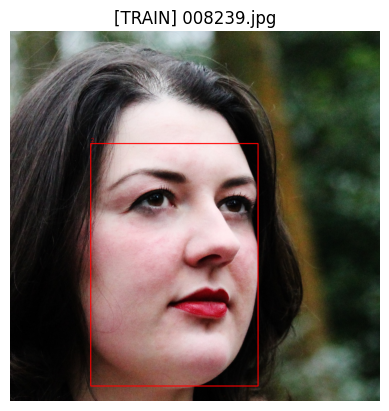

[VAL] sample image: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\val\images\004379.jpg
[VAL] sample label: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\PWMFD_YOLO\val\labels\004379.txt


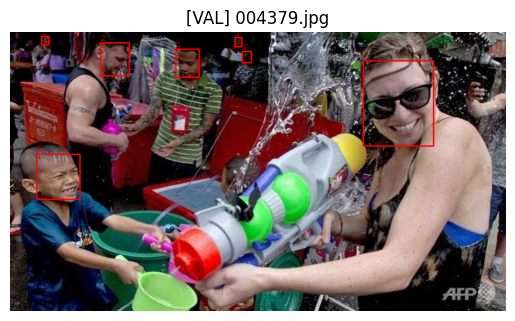

In [44]:
import random
import cv2
import matplotlib.pyplot as plt

def show_random_sample(img_dir, label_dir, title_prefix=""):
    img_list = [f for f in os.listdir(img_dir)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    img_name = random.choice(img_list)

    img_path = os.path.join(img_dir, img_name)
    label_path = os.path.join(
        label_dir,
        os.path.splitext(img_name)[0] + ".txt"
    )

    print(f"{title_prefix} sample image:", img_path)
    print(f"{title_prefix} sample label:", label_path)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            cls_id, xc, yc, bw, bh = map(float, line.strip().split())
            xc *= w
            yc *= h
            bw *= w
            bh *= h

            xmin = int(xc - bw/2)
            xmax = int(xc + bw/2)
            ymin = int(yc - bh/2)
            ymax = int(yc + bh/2)

            color = (255, 0, 0)
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
            cv2.putText(img, str(int(cls_id)), (xmin, ymin-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{title_prefix} {img_name}")
    plt.show()

# thư mục labels tương ứng
train_label_dir = os.path.join(out_root, "train", "labels")
val_label_dir   = os.path.join(out_root, "val", "labels")

show_random_sample(train_img_dir, train_label_dir, title_prefix="[TRAIN]")
show_random_sample(val_img_dir,   val_label_dir,   title_prefix="[VAL]")
